<a href="https://colab.research.google.com/github/Romanvia93/traffic_sign_detection/blob/main/yolo/notebooks/Yolov5_w_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic Sign Detection Project Report
* Thien An Trinh
* Roman Burekhin
* Athira Devan
* Lester Azinge

## Abstract

This project aims to train, benchmark and deloy an object detection model to detect 4 types of traffic signs: `traffic light`, `stop`, `speed limit`, and `crosswalk`. The chosen models for the project were `YOLOv5`, `EfficientDet D1`, `SSD MobileNet FPNLite`, `SSD ResNet50 FPN`, and `Faster R-CNN ResNet50`. There are two frameworks for model training, evaluation and inference: `YOLOv5` belongs to [Ultralytics](https://github.com/ultralytics/yolov5) and the rest belong to [Tensorflow](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Our experiments showed that among the tested models, `YOLOv5` is the best - It won in all criteria including precision, speed, size, and training time, and therefore  was chosen for a video inference (available in `yolo/videos` directory) and a [Streamlit deployment](https://trafficsigns.streamlit.app/). Besides, among the TensorFlow models, `SSD MobileNet FPNLite` is the best model. Hence, it was chosen to run a realtime webcam test on a local machine. The screen recording of this demo is available in `tensorflow/videos` directory.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

## 1. Introduction

### 1.1. Problem Statement

We are living in a world that is moving towards automation. From robot arms assembling individual components into complete cars to smart household appliances that have been transforming our homes, the benefits of autonomous applications are undeniable. The automobile industry is following the same trend. Not only autopilot systems assist drivers by bringing them better driving experience, but they can also help reduce the number of accidents. For example, a vehicle with a smart traffic sign detection system can “see” all the signs ahead including those the driver could miss, and thereby perform proper actions timely in time-sensitive situation.

In that context, our project focused two paramount objectives: (1) to meticulously **benchmark** a range of model architectures to identify the most optimal and efficient solution for this challenging task, and (2) to **deploy** and demonstrate precise and reliable detection of critical traffic signs.  

Before proceeding into further detail, it is crucial to address certain concepts related to how the task was framed:
1. The project is a `computer vision` task – a domain in which images are processed and analyzed in order to extract useful information that can drive decision-making (Arabnia et al., 2018; Yoshida, 2011).  
<br>
2. This project is specifically an `object detection` task where an image was analyzed not for obtaining the semantic meaning of the whole image (i.e., `image classification`), or for segmenting the image into meaningful regions (i.e., `image segmentation`), but rather to identify targeted objects that are present in the images and determine where on the images they are located. In this project, the objects of interest were `traffic lights`, `stop` signs, `speed limit` signs and `crosswalk` signs, which are the fundamental elements that guide drivers and traffic flow. Third, the algorithms required for this task were defined to be *deep learning (DL)  convolutional neural networks (CNNs)* which has always been the state-of-the-art in the domain for a decade.  
<br>
3. The project also leveraged an advanced DL technique called transfer learning, in which neural networks that were pretrained on a large dataset are fine-tuned on the dataset of interest instead of being trained from scratch, and therefore are capable of attaining high evaluation scores in the new domain. The details of the data, pretrained-models, training and evaluation frameworks are now discussed in the following section.


### 1.2. Related Work

The authors took [this YOLOv5 turorial](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb) and [this TensorFlow tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html) as the starting point for the work of this project.

## 2. Methodology

### 2.1. Data

#### 2.1.1. Data Source

The data for this project was from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection). The dataset comprises of two folders, each of which consists of 877 files. The first folder is named **“images”** which contains 877 road sign images in PNG, whereas the other is named **“annotations”** and has 877 corresponding XML files that store the image annotations in the PASCAL VOC format (Everingham et al., 2015). The images belong to 4 distinct classes, namely `traffic light,` `stop`, `speed limit`, and `crosswalk` which are the target objects to detect (`Figure 1`, `Figure 2`). 

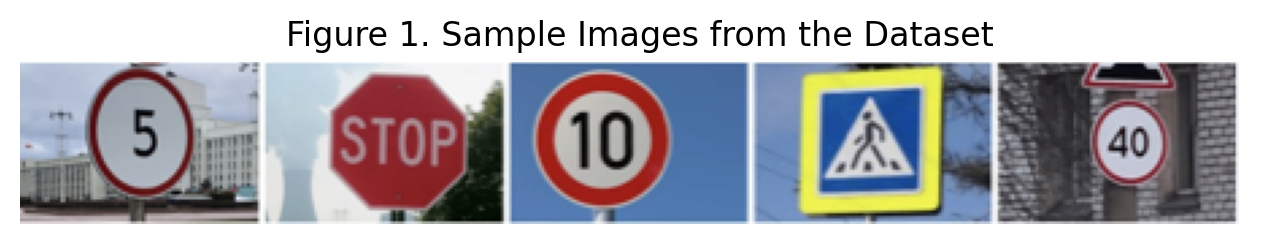

In [26]:
img = Image.open("../report/report_images/sample_data_images.png")
plt.figure(figsize=(8, 8))
fig = plt.imshow(img)
plt.title("Figure 1. Sample Images from the Dataset")
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

(image obtained from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection))

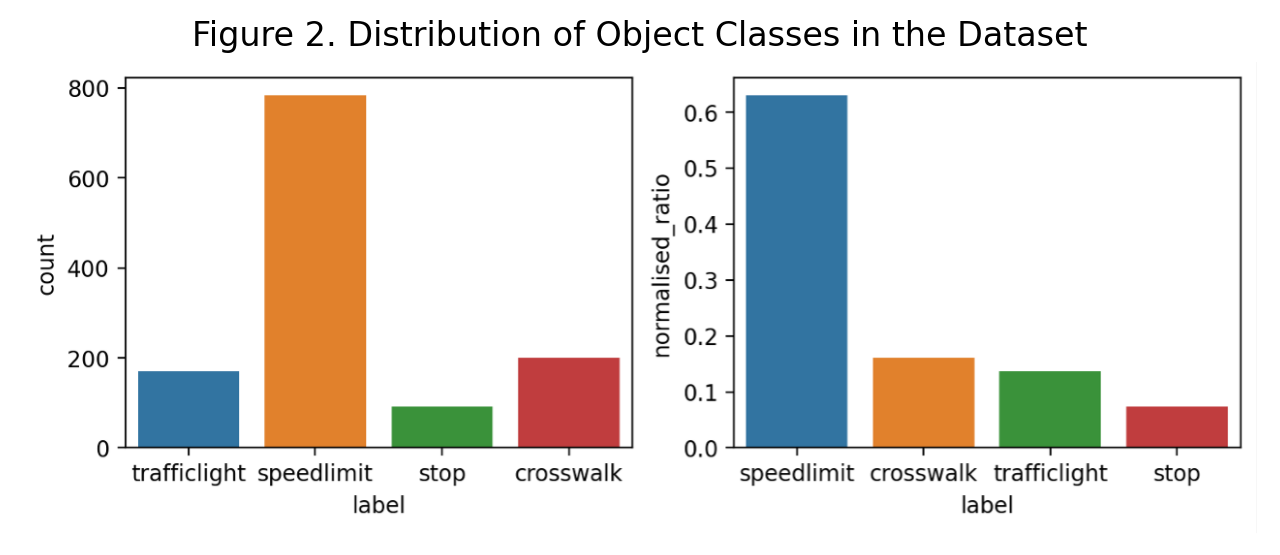

In [24]:
img = Image.open("../report/report_images/data_distribution.png")
plt.figure(figsize=(8, 8))
plt.title("Figure 2. Distribution of Object Classes in the Dataset")
fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

#### 2.1.2. Data Preprocessing

The data was split into a training and a validation set with the ratio of 4:1. As a result, the training set contained 701 images and the validation set had 176. Additionally, since the original format of the annotations were not ready to be used in the training pipeline, label format conversion was performed. Since the models used in the experiments required two different training frameworks, there were two types of conversion. The first framework was the `TensorFlow object detection API` which required the annotations in `TFRecord` format, while the Ultralytics framework for `YOLOv5` expected the annotations in text format with each line describing the bounding boxes of the objects. More details of the frameworks are discussed in **Section 2.2**. It is notable that the training and validation sets had separate annotation conversion, so that resulting files were distinctly addressed in the training configuration to be the training and validation annotations respectively. Further details of the data preprocessing steps can be found in the experimental Jupyter notebooks.

#### 2.1.3. Data Augmentation

Data augmentation is a technique that helps diversify the training data by adding variations to the images. For fair benchmarking and evaluation, similar augmentations had to be used in both frameworks (e.g., if the `TensorFlow` models used shearing at 30 degree, `YOLOv5` had to use the same transformation), meaning that we could only choose the augmentation options that were available in both frameworks. Additionally, in the context of traffic sign detection, some transformations would not be applicable such as vertical or horizontal flips, or 90 degree rotation. Due to these requirements, there were a limited number of options available that could be utilized. In this project, we could select only one augmentation option that fitted the situation, and it was image scaling (Figure 3, Figure 4). Nevertheless, this single augmentation proved to be effective as described in detail in a later section of this report.

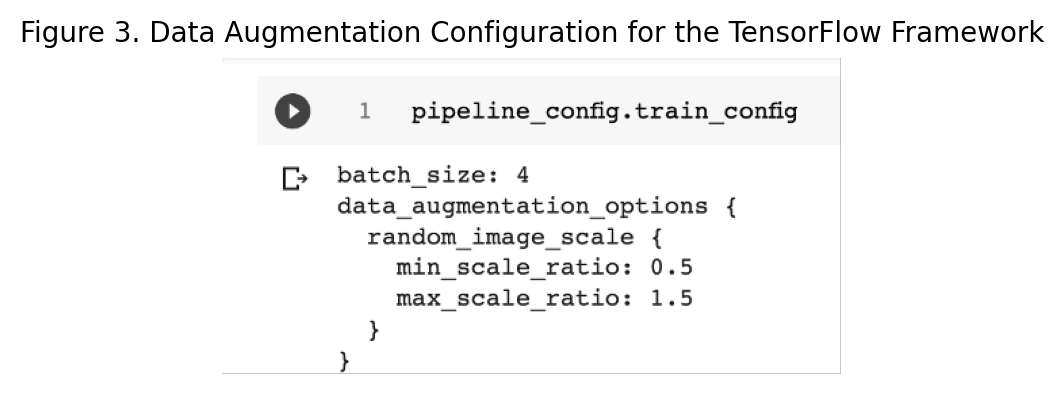

In [29]:
img = Image.open("../report/report_images/augmentation_tf.png")
plt.figure(figsize=(4, 4))
fig = plt.imshow(img)
plt.title("Figure 3. Data Augmentation Configuration for the TensorFlow Framework", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

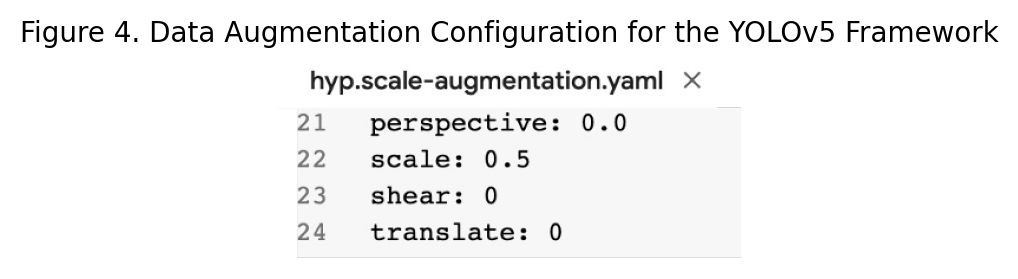

In [30]:
img = Image.open("../report/report_images/augmentation_yolo.png")
plt.figure(figsize=(3, 3))
fig = plt.imshow(img)
plt.title("Figure 4. Data Augmentation Configuration for the YOLOv5 Framework", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2. Models and Frameworks

#### 2.2.1.	Single Shot MultiBox Detector (SSD)

The Single Shot MultiBox Detector was firstly introduced in 2015 (Liu et al., 2015). This CNN architecture employs a set of default boxes of various aspect ratios and scales which, upon inference, can be adjusted to match the object shapes for better detection. Moreover, to cope with objects of different sizes, it leverages the fact that different feature maps have different resolutions, and therefore uses multiple predictions from these layers to compute the final detections. `Figure 5` describes the working mechanism of an SSD network and is taken from the original paper. Note that in `Figure 5(a)` there are two objects of different shapes and sizes, of which smaller object can be better detected with the blue default box on a higher resolution feature map (`Figure 5(b)`), while the location of the larger object would be more efficiently detected by the red default box on a lower resolution one (`Figure 5(c)`).

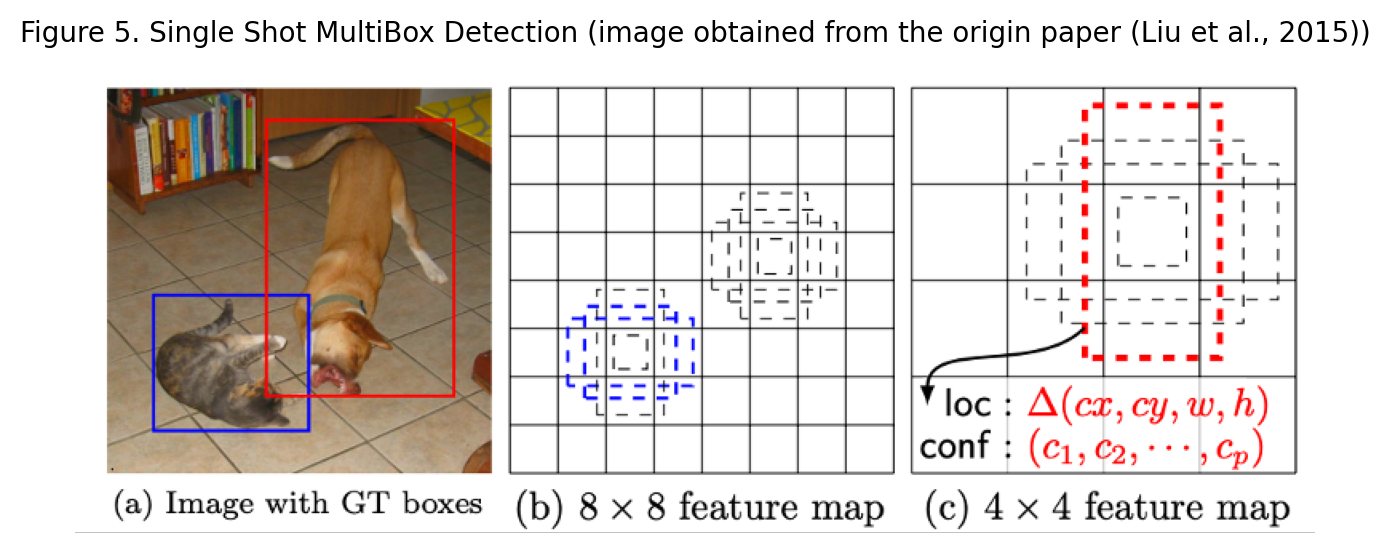

In [37]:
img = Image.open("../report/report_images/ssd.png")
plt.figure(figsize=(8, 8))
plt.title("Figure 5. Single Shot MultiBox Detection (image obtained from the origin paper (Liu et al., 2015))", size=10)
fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2.2. Faster R-CNN

A competitor of the SSD family is the Faster Region-based Convolutional Neural Networks (Faster R-CNN), which was introduced also in 2015 (Ren et al., 2015). Unlike SSD models, R-CNNs are two-stage object detection algorithms that (1) produce region proposals that suggest the location of the objects based on which (2) boundary boxes and objectness scores are predicted. In Faster R-CNN architecture, the author introduced a Region Proposal Network (RPN) that address the model’s slow runtime issue which had been the bottleneck of any two-stage object detection networks.

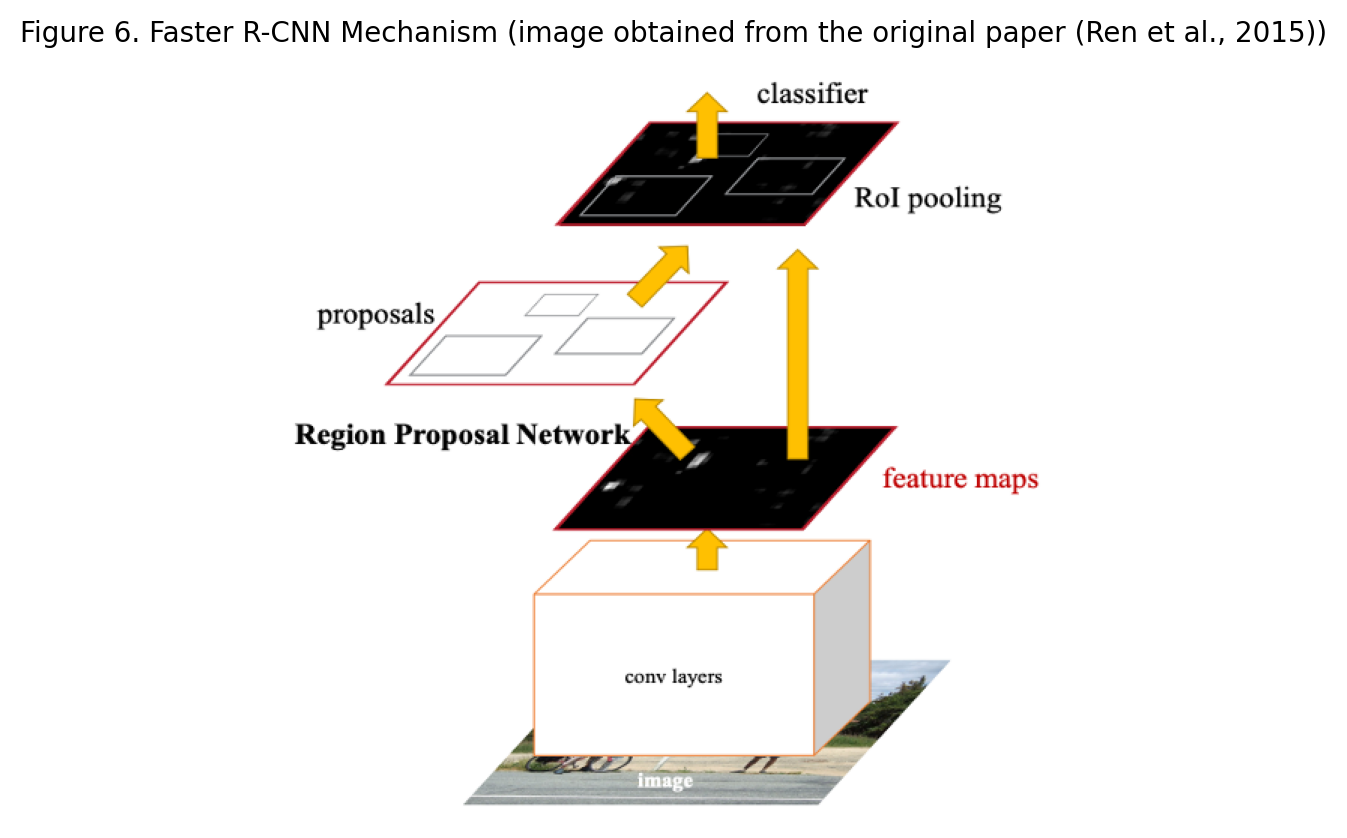

In [38]:
img = Image.open("../report/report_images/faster_rcnn.png")
plt.figure(figsize=(5, 5))
fig = plt.imshow(img)
plt.title("Figure 6. Faster R-CNN Mechanism (image obtained from the original paper (Ren et al., 2015))", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2.3.	You Only Look Once (YOLO)

You Only Look Once (YOLO) was another framework that was introduced in 2015 (Redmon et al., 2015) whose one of the prominent features is that it is extremely fast. In YOLO architecture, an image is divided into an S x S grid, and on each grid cell the model predicts B bounding boxes (where each bounding box consists of 5 values, x, y, w, h and confidence) and the object class. With this mechanism the model sees the whole image once and therefore it is a single-stage object detection algorithm. Since the introduction of the original architecture, there has been much evolution of the YOLO family, resulting in `YOLOv2` (Redmon & Farhadi, 2016), `YOLOv3` (Redmon & Farhadi, 2018), `YOLOv4` (Bochkovskiy et al., 2020), `YOLOv5` (Ultralytics), `YOLOv6` (Li et al., 2022), `YOLOv7` (Wang et al., 2022), and most recently `YOLOv8` (Ultralytics). This study used YOLOv5 for benchmarking and deployment.

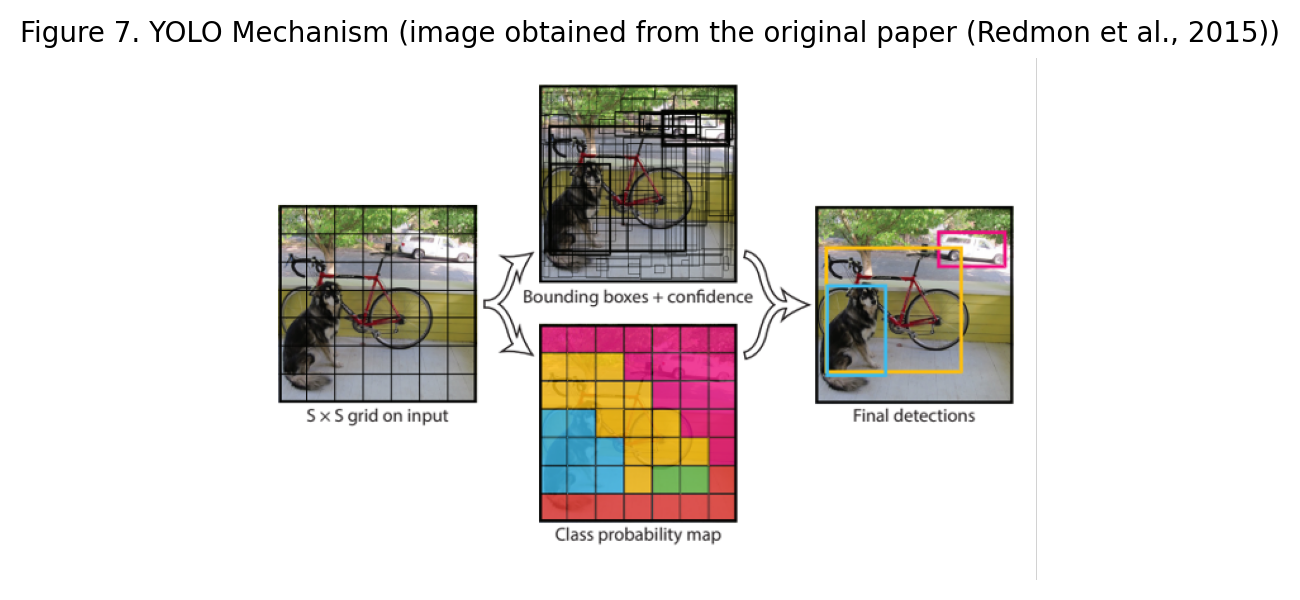

In [39]:
img = Image.open("../report/report_images/yolo.png")
plt.figure(figsize=(5, 5))
fig = plt.imshow(img)
plt.title("Figure 7. YOLO Mechanism (image obtained from the original paper (Redmon et al., 2015))", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.2.4. Frameworks

To achieve high precision, the models were not built and trained from scratch but instead via `transfer learning`. Specifically, the models were downloaded with pretrained weights and thereby served as a starting point for fine-tuning. The pretrained models were obtained from two sources: the `SSD` and `Faster R-CNN` models were acquired from the [TensorFlow2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) (`Figure 8`), while the pretrained YOLOv5 was obtained by cloning the model’s repository on [GitHub](https://github.com/ultralytics/yolov5) (`Figure 9`). 

On Figure 8, highlighted in red boxes are the chosen models from Model Zoo:
* EfficientDet D1
* SSD MobileNet FPNLite
* SSD ResNet50 FPN (RetinaNet50)
* Faster R-CNN ResNet50.

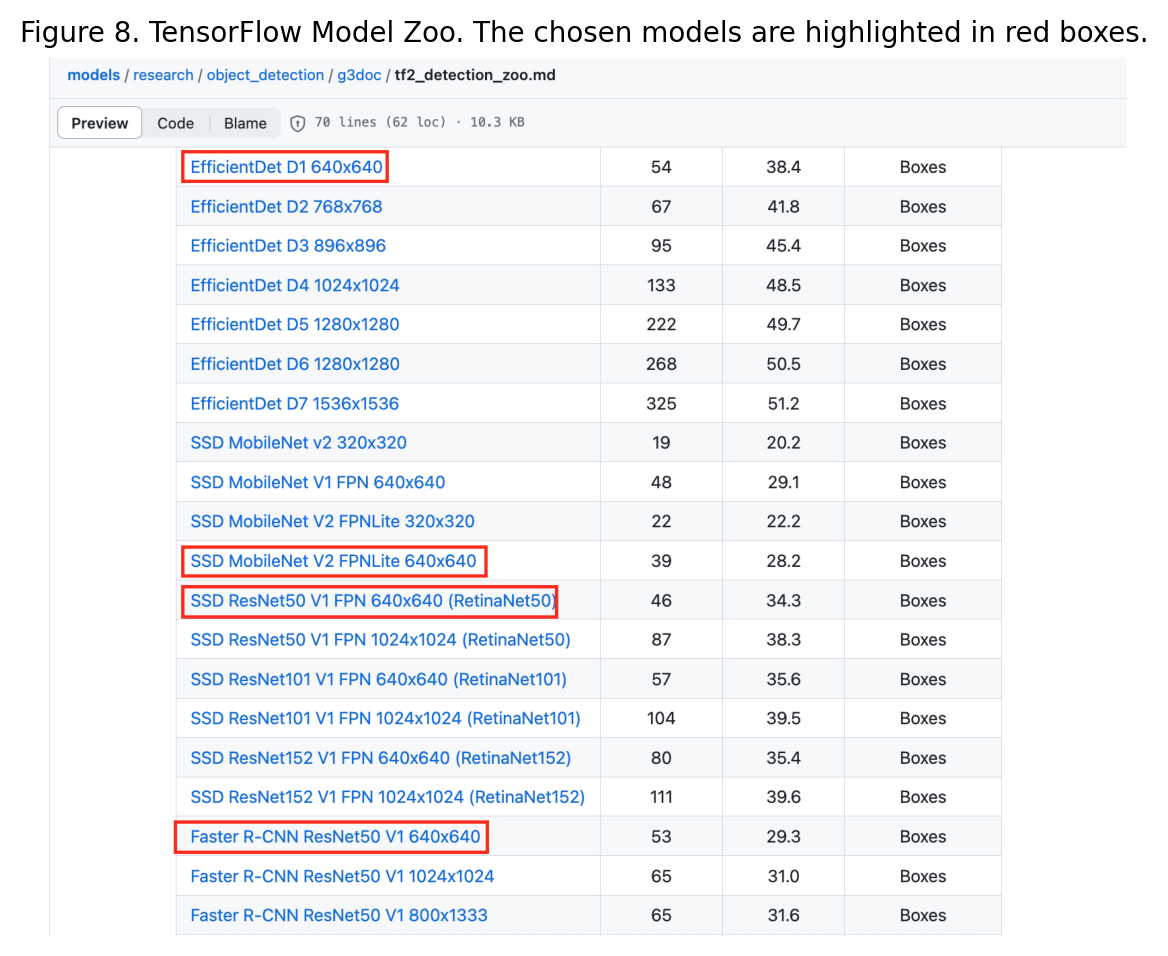

In [40]:
img = Image.open("../report/report_images/modelzoo.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.title("Figure 8. TensorFlow Model Zoo. The chosen models are highlighted in red boxes.", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

There are some points worth highlighting. First, all of the chosen models had similar training resolution of 640x640, and so does YOLOv5, to ensure **fair benchmarking**. Second, there were SSD and Faster R-CNN models of similar ResNet50 backbone so SSD can be compared against Faster R-CNN in this task. Third, since the project focused on not only experimenting but also deployment, the model list was extended to included SSD MobileNet and EfficientDet. On the one hand, MobileNet is a CNN developed by Google which were claimed to be **suitable on mobile and embedded device** (Howard et al., 2017). On the other hand, EfficientDet is an object detection network family which utilizes compound scaling method and weighted bi-directional feature pyramid network (BiFPN) to **optimize model efficiency** (Tan et al., 2019). Since these two models were claimed to be efficient in terms of speed and size, they were considered suitable candidates for deployment and hence were involved in this project.

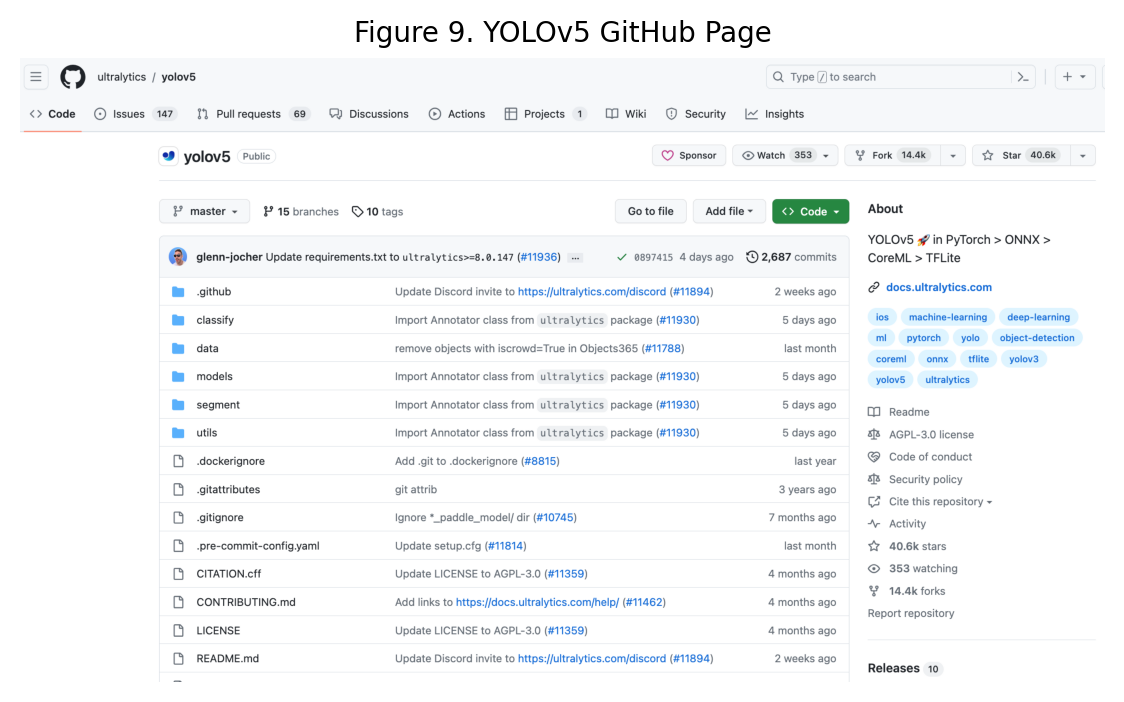

In [41]:
img = Image.open("../report/report_images/ultralytics_yolov5.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.title("Figure 9. YOLOv5 GitHub Page", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 2.3. Training and Evaluation

After the dataset and the models had been defined, model training was performed. Since there was no GPU available in any of the team members’ computers, the models were trained on Google Colab notebooks to utilize the free-of-charge GPUs that were provided by the service. To fit the training data to the GPUs, the training batch size was set to be 4, and in the TensorFlow framework the models were trained for **5000 training steps** (`Figure 10`). The YOLOv5 framework required number of epochs instead of training steps to be specified, therefore, with the **batch size of 4** and the number of training instances equal to 701, a calculation was done to convert 5000 training steps to the equivalent value of **29 epochs** (`Figure 11`).

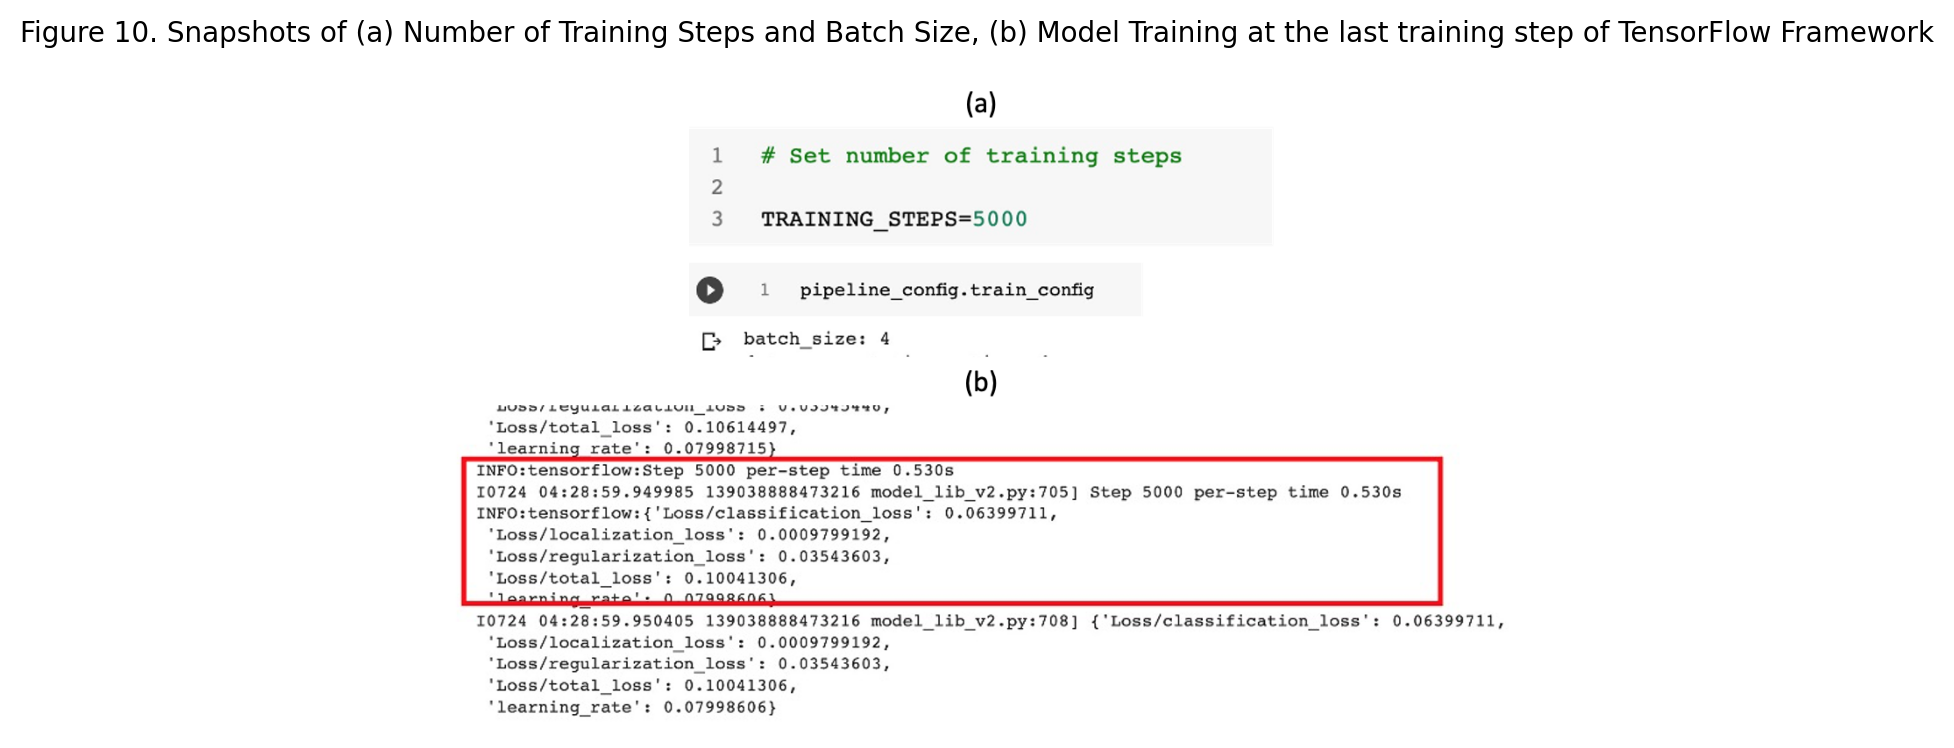

In [42]:
img = Image.open("../report/report_images/tf_training.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 10. Snapshots of (a) Number of Training Steps and Batch Size, (b) Model Training at the last training step of TensorFlow Framework", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

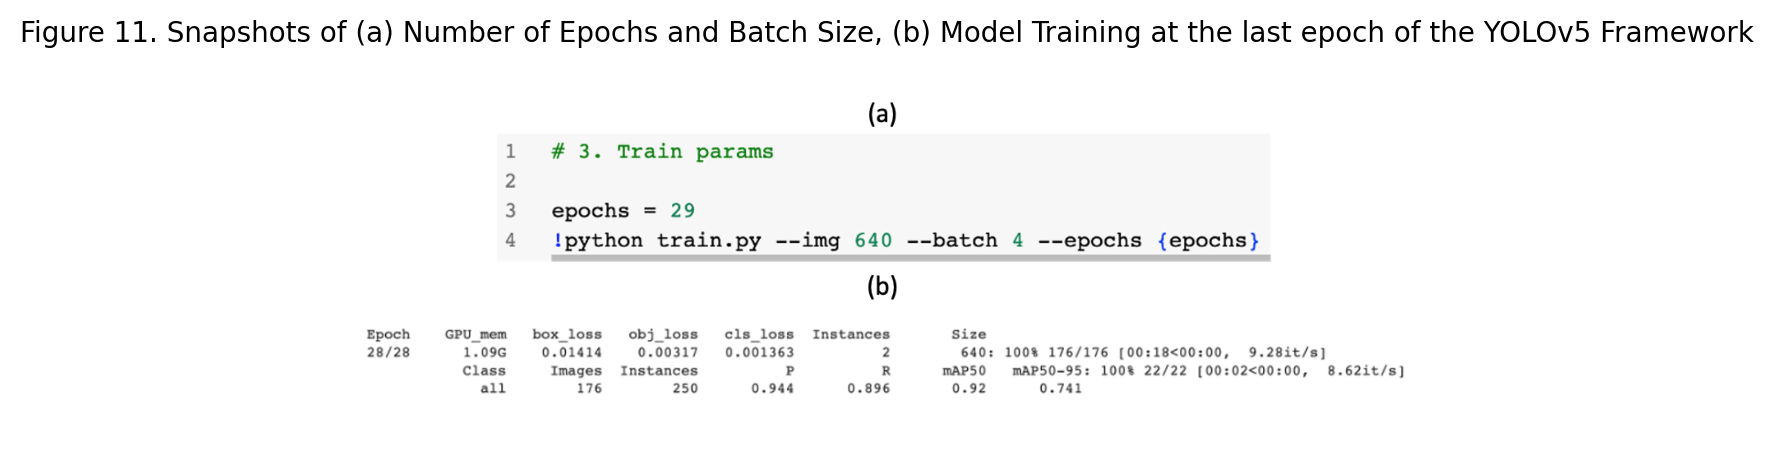

In [43]:
img = Image.open("../report/report_images/yolo_training.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 11. Snapshots of (a) Number of Epochs and Batch Size, (b) Model Training at the last epoch of the YOLOv5 Framework", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

Following model training was the model evaluation step which generated the precision scores as shown on Figure 12 and Figure 13. These precision values, together with other evaluation metrics of interest such as inference speed, model size and training time were collected and comprehensively presented in `Section 3` of this report.

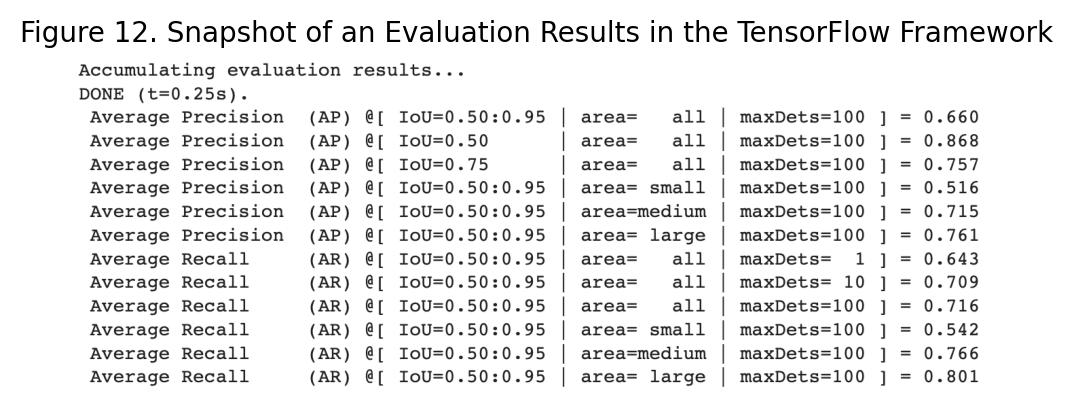

In [44]:
img = Image.open("../report/report_images/tf_evaluation.png")
plt.figure(figsize=(6, 6))
fig = plt.imshow(img)
plt.title("Figure 12. Snapshot of an Evaluation Results in the TensorFlow Framework", size=10)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

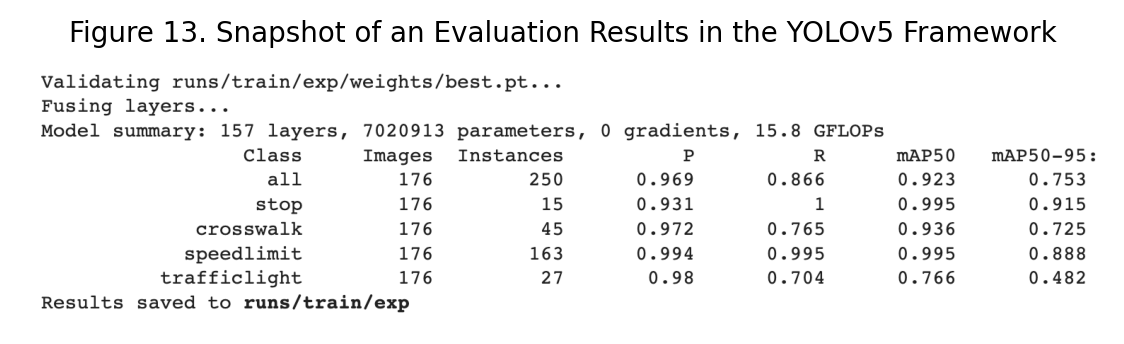

In [45]:
img = Image.open("../report/report_images/yolo_evaluation.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 13. Snapshot of an Evaluation Results in the YOLOv5 Framework", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## 3. Results and Discussion

### 3.1. mAP

`Figure 14` and `Figure 15` show the mAPs of the models evaluated on the validation set at IoU=0.5:0.95 and IoU=0.5, respectively. There are three points worth highlighting. First, **YOLOv5 achieved the highest scores among all the models**, with mAP≈0.75 at IoU=0.5:0.95 and 0.92 at IoU=0.5, while between the TensorFlow models, Faster R-CNN ResNet50 attained the highest precisions with SSD MobileNet FPNLite closely followed. Second, except for EfficientDet D1, **augmentation improved the model's precisions** thanks to the enhanced diversification of the training images. Lastly, our mAP results do not follow the trend reported on the Model Zoo where EfficientDet D1 scored the best, followed by the SSD ResNet50 FPN. This proves that different models performed differently on different datasets and therefore, selecting an optimal model for a specific use case requires thorough experimenting and benchmarking procedures.

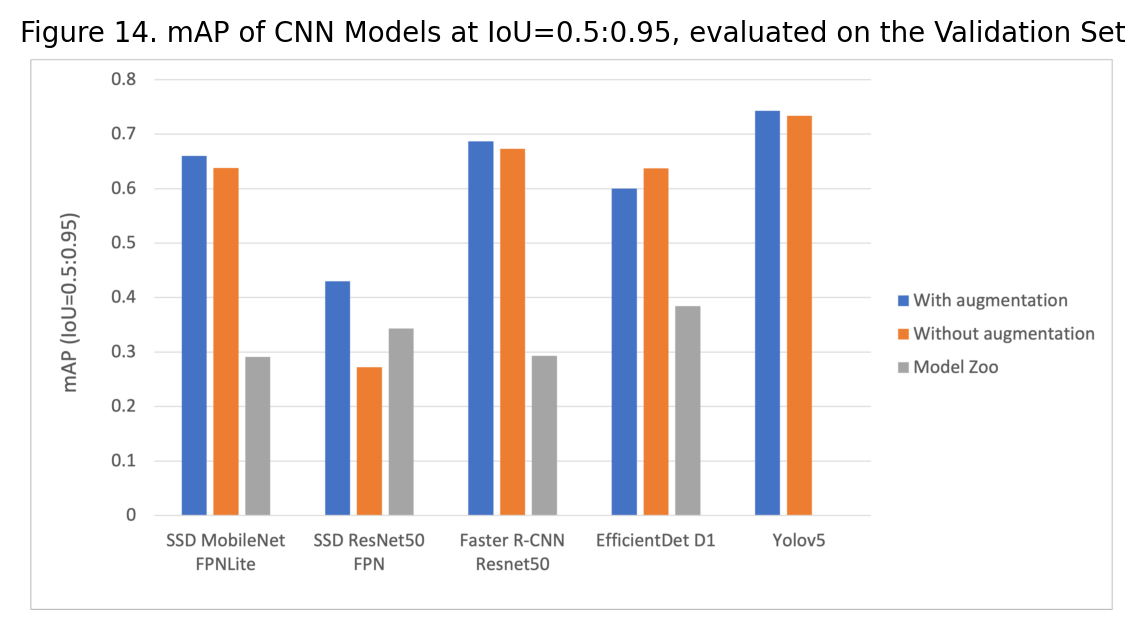

In [46]:
img = Image.open("../report/report_images/mAP.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 14. mAP of CNN Models at IoU=0.5:0.95, evaluated on the Validation Set", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

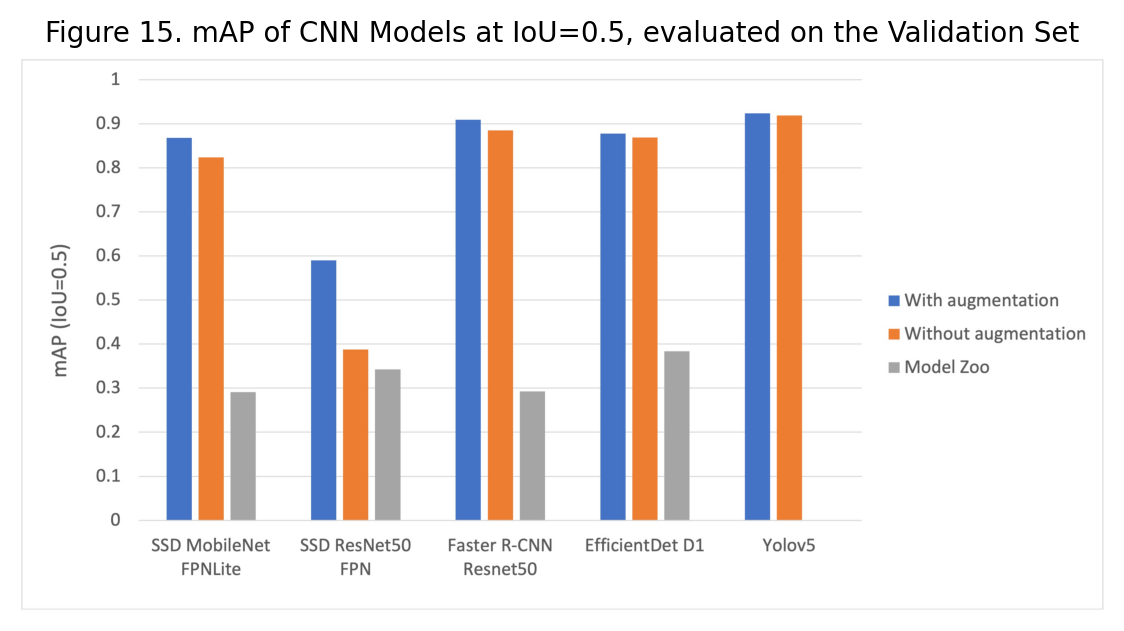

In [47]:
img = Image.open("../report/report_images/mAP05.jpg")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 15. mAP of CNN Models at IoU=0.5, evaluated on the Validation Set", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 3.2. Speed

`Figure 16` displays the models’ average inference time when testing on several test images. Faster R-CNN ResNet50, although was the model achieved the highest precision scores, took the longest time when detecting traffic signs on the test images, making it less preferable for real-time applications. On the other hand, SSD MobileNet FPNLite and EfficientDet D1, while being slightly lower in terms of precisions compared to Faster R-CNN ResNet50, respectively took only haft and one-third of the time of Faster R-CNN ResNet50 to run. These results could be attributed to the fact that SSD models perform detection in a single stage, while Faster R-CNNs are two-state object detectors. However, SSD models were not the fastest in our study: among all the models, **YOLOv5 again stands out as the model with the fastest inference speed**.

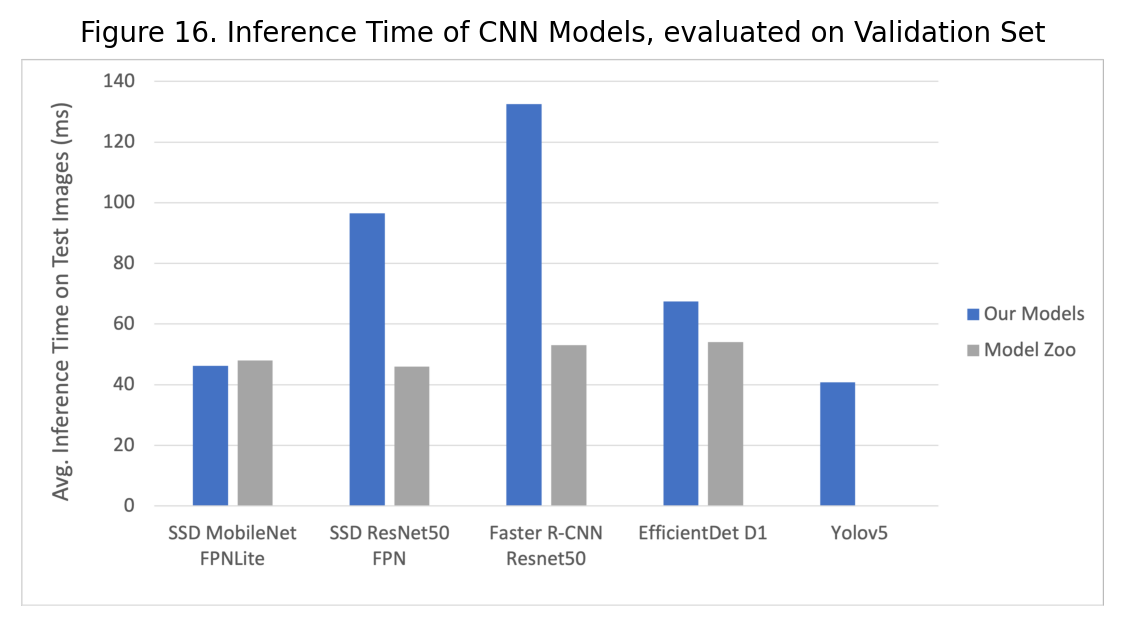

In [48]:
img = Image.open("../report/report_images/speed.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 16. Inference Time of CNN Models, evaluated on Validation Set", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 3.3. Size

On edge devices, a suitable model can be slightly less precise so long as the sacrifice of precision allows for a much lighter weight. In terms of model package size, `Figure 17` indicates that **YOLOv5 and SSD MobileNet FPNLite are the smallest models**, followed by EfficientDet D1, while SSD ResNet50 FPN and Faster R-CNN ResNet50 occupy the largest storage amounts. Here one would see that YOLOv5, SSD MobileNet FPNLite and EfficientDet D1 were not only optimized for speed (Figure 16), but also for size (Figure 17), which renders them suitable options for deployment on edge devices. It is worth highlighting that YOLOv5 was exported and stored in a format different from the TensorFlow models. Among all the models, YOLOv5 continued being the best in terms of size, whereas between the TensorFlow CNNs, SSD MobileNet FPNLite is the lightest model as its name suggests.

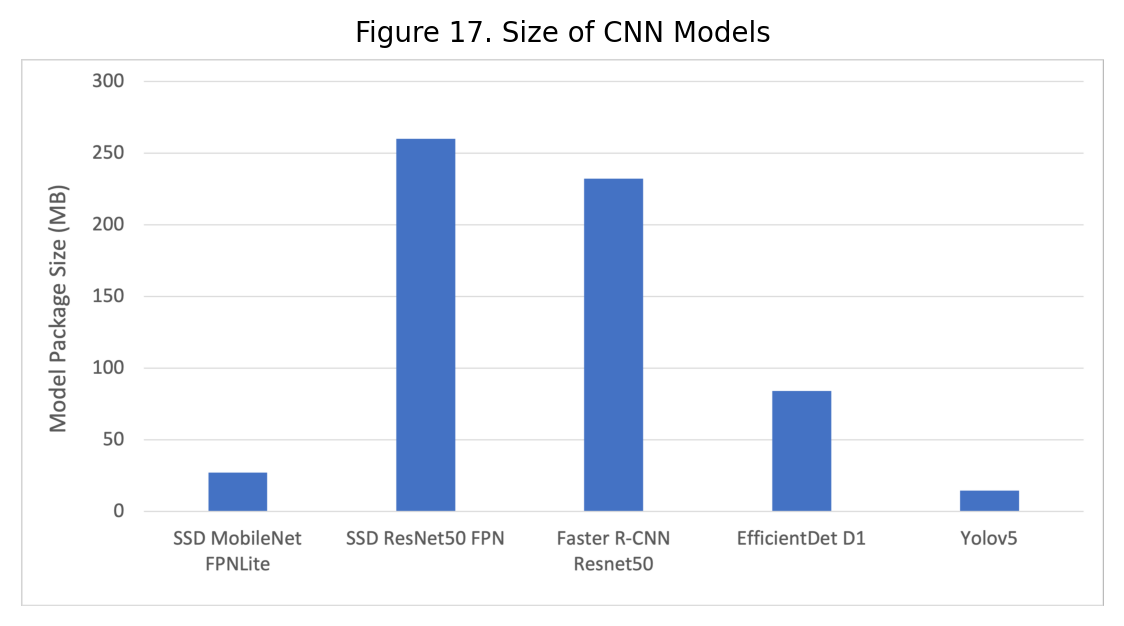

In [49]:
img = Image.open("../report/report_images/size.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 17. Size of CNN Models", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 3.4. Training Time

A process of selecting a model includes not only inference but also training process, and the time a model would take for training is a metric indicating the training cost (`Figure 18`). One more time **YOLOv5 beat the TensorFlow models by being the fastest model to train** (≈0.1-0.13s per training step). Among the TensorFlow models, in terms of model training SSD MobileNet FPNLite again appeared to be a good candidate, while EfficientDet D1 seemed to be no longer a preferable option. It is also notable that while data augmentation enhanced precision (Figure 14 and Figure 15), it also increased the training time (`Figure 18`) due to the introduction of an augmentation step in the training pipeline.

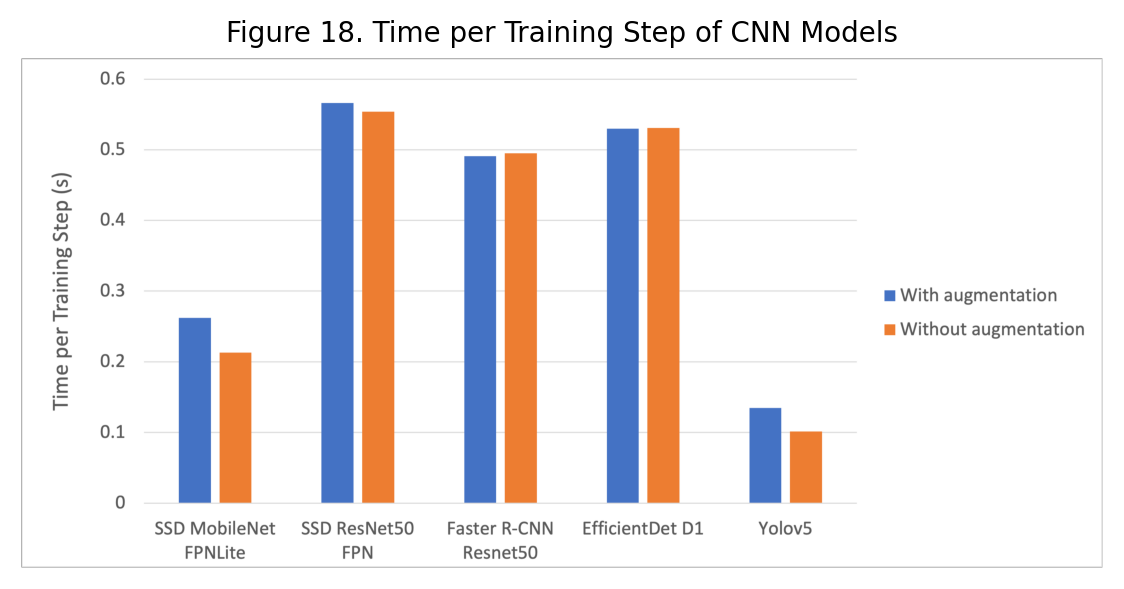

In [50]:
img = Image.open("../report/report_images/training_time.png")
plt.figure(figsize=(7, 7))
fig = plt.imshow(img)
plt.axis('off')
plt.title("Figure 18. Time per Training Step of CNN Models", size=10)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### 3.5. Model Selection Summary

Based on the evaluation results, Table 1 summarizes the best model for each criterion, with a double tick mark indicating the best model and a single tick mark indicating the second best, where applicable.

*Table 1. Best Model Selections in each Criterion, based on Evaluation Results*

|  | SSD MobileNet | SSD ResNet50 FPN | Faster R-CNN ResNet50 | Efficient Det D1 | YOLOv5 |
|:-:|:-:|:-:|:-:|:-:|:-:|
|Precision| | |x| |xx|
|Speed|x| | | |xx|
|Size|x| | | |xx|
|Training Time|x| | | |xx|

YOLOv5 won in all criteria, while SSD MobileNet FPNLite led in three out of four metrics among the TensorFlow family. In terms of precision, the previous section has pointed out that the difference between SSD MobileNet FPNLite and Faster R-CNN ResNet50 was indeed insignificant. If selecting only from TensorFlow models, the SSD MobileNet is a most suitable candidate.

## 4. Conclusion

This report describes in detail our process of developing traffic sign detection application, from conceptualization to model training, and to deployment. Our results showed that YOLOv5 stood out to be the most optimal model in all criteria, while SSD MobileNet FPNLite was the winner among the TensorFlow options. Our demonstrations also visualized how the trained object detection models worked on images, videos, and in real-time via webcam, and how it worked on Streamlit.

We hope that our work has provided some useful insights into the field, and paved the way for a safer, more efficient and autonomous driving experience. As we proceed to extend this project in future work, we wish to continue to help reshape the landscape of mobility for the better, and impact countless lives on the road.


## 5. References

Arabnia, H. R., Deligiannidis, L., & Tinetti, F. G. (2018). Image Processing, Computer Vision, and Pattern Recognition. C.S.R.E.A.  
<br>
Bochkovskiy, A., Wang, C.-Y., & Liao, H.-Y. M. (2020). YOLOv4: Optimal Speed and Accuracy of Object Detection. arXiv:2004.10934. Retrieved April 01, 2020, from https://ui.adsabs.harvard.edu/abs/2020arXiv200410934B  
<br>
Everingham, M., Eslami, S. M. A., Van Gool, L., Williams, C. K. I., Winn, J., & Zisserman, A. (2015). The Pascal Visual Object Classes Challenge: A Retrospective. International Journal of Computer Vision, 111(1), 98-136. https://doi.org/10.1007/s11263-014-0733-5  
<br>
Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., Andreetto, M., & Adam, H. (2017). MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications. arXiv:1704.04861. Retrieved April 01, 2017, from https://ui.adsabs.harvard.edu/abs/2017arXiv170404861H  
<br>
Li, C., Li, L., Jiang, H., Weng, K., Geng, Y., Li, L., Ke, Z., Li, Q., Cheng, M., Nie, W., Li, Y., Zhang, B., Liang, Y., Zhou, L., Xu, X., Chu, X., Wei, X., & Wei, X. (2022). YOLOv6: A Single-Stage Object Detection Framework for Industrial Applications. arXiv:2209.02976. Retrieved September 01, 2022, from https://ui.adsabs.harvard.edu/abs/2022arXiv220902976L  
<br>
Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C.-Y., & Berg, A. C. (2015). SSD: Single Shot MultiBox Detector. arXiv:1512.02325. Retrieved December 01, 2015, from https://ui.adsabs.harvard.edu/abs/2015arXiv151202325L  
<br>
Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2015). You Only Look Once: Unified, Real-Time Object Detection. arXiv:1506.02640. Retrieved June 01, 2015, from https://ui.adsabs.harvard.edu/abs/2015arXiv150602640R  
<br>
Redmon, J., & Farhadi, A. (2016). YOLO9000: Better, Faster, Stronger. arXiv:1612.08242. Retrieved December 01, 2016, from https://ui.adsabs.harvard.edu/abs/2016arXiv161208242R  
<br>
Redmon, J., & Farhadi, A. (2018). YOLOv3: An Incremental Improvement. arXiv:1804.02767. Retrieved April 01, 2018, from https://ui.adsabs.harvard.edu/abs/2018arXiv180402767R  
<br>
Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. arXiv:1506.01497. Retrieved June 01, 2015, from https://ui.adsabs.harvard.edu/abs/2015arXiv150601497R  
<br>
Road Sign Detection. https://www.kaggle.com/datasets/andrewmvd/road-sign-detection  
<br>
Tan, M., Pang, R., & Le, Q. V. (2019). EfficientDet: Scalable and Efficient Object Detection. arXiv:1911.09070. Retrieved November 01, 2019, from https://ui.adsabs.harvard.edu/abs/2019arXiv191109070T  
<br>
TensorFlow.  https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md 
<br>
Ultralytics. YOLOv5. https://ultralytics.com/yolov5  
<br>
Ultralytics. YOLOv8. https://ultralytics.com/yolov8  
<br>
Wang, C.-Y., Bochkovskiy, A., & Liao, H.-Y. M. (2022). YOLOv7: Trainable bag-of-freebies sets new state-of-the-art for real-time object detectors. arXiv:2207.02696. Retrieved July 01, 2022, from https://ui.adsabs.harvard.edu/abs/2022arXiv220702696W  
<br>
Yoshida, S. R. (2011). Computer vision. Nova Science Publishers, Inc.  
